In [25]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt 
import rasterio
from matplotlib.patches import Rectangle
from shapely.geometry import box, Point
import os

In [26]:
df_1=pd.read_csv(r"C:\Users\rishi\ml_projects\climate\lat_lon_label_3_points.csv")
df_2=pd.read_csv(r"C:\Users\rishi\ml_projects\climate\lat_lon_label_4_points.csv")

In [27]:
tif_paths=[
    r"C:\Users\rishi\ml_projects\climate\500_18\CO\response.tiff",
    r"C:\Users\rishi\ml_projects\climate\500_18\HCHO\response.tiff",
    r"C:\Users\rishi\ml_projects\climate\500_18\NO2\response.tiff",
    r"C:\Users\rishi\ml_projects\climate\500_18\O3\response.tiff",
    r"C:\Users\rishi\ml_projects\climate\500_18\SO2\response.tiff",
]

In [28]:
tif_paths_2=[
    r"C:\Users\rishi\ml_projects\climate\500_23\CO\response.tiff",
    r"C:\Users\rishi\ml_projects\climate\500_23\HCHO\response.tiff",
    r"C:\Users\rishi\ml_projects\climate\500_23\NO2\response.tiff",
    r"C:\Users\rishi\ml_projects\climate\500_23\O3\response.tiff",
    r"C:\Users\rishi\ml_projects\climate\500_23\SO2\response.tiff"
]

In [29]:
tif_paths=tif_paths+tif_paths_2

In [30]:
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'
gdf = gpd.read_file(shapefile_path)
#gdf.plot()

In [31]:
gdf_points_peri = gpd.GeoDataFrame(
    df_1, 
    geometry=gpd.points_from_xy(df_1['LON'], df_1['LAT']),
    crs="EPSG:4326"  # Set the coordinate reference system (WGS84)
)

In [32]:
gdf_points_urban = gpd.GeoDataFrame(
    df_2, 
    geometry=gpd.points_from_xy(df_2['LON'], df_2['LAT']),
    crs="EPSG:4326"  # Set the coordinate reference system (WGS84)
)

In [33]:
o_path_1=r"C:\Users\rishi\ml_projects\climate\500_18\O3\response.tiff"
o_path_2=r"C:\Users\rishi\ml_projects\climate\500_23\O3\response.tiff"
o_map=[]
def get_min_max(tiff_path):
    with rasterio.open(tiff_path) as src:
        raster_data = src.read(1)
        vmin, vmax = np.nanmin(raster_data), np.nanmax(raster_data)
    return vmin, vmax

# Get min and max from both TIFFs
vmin1, vmax1 = get_min_max(o_path_1)
vmin2, vmax2 = get_min_max(o_path_2)

omap=(vmin2,vmax2)

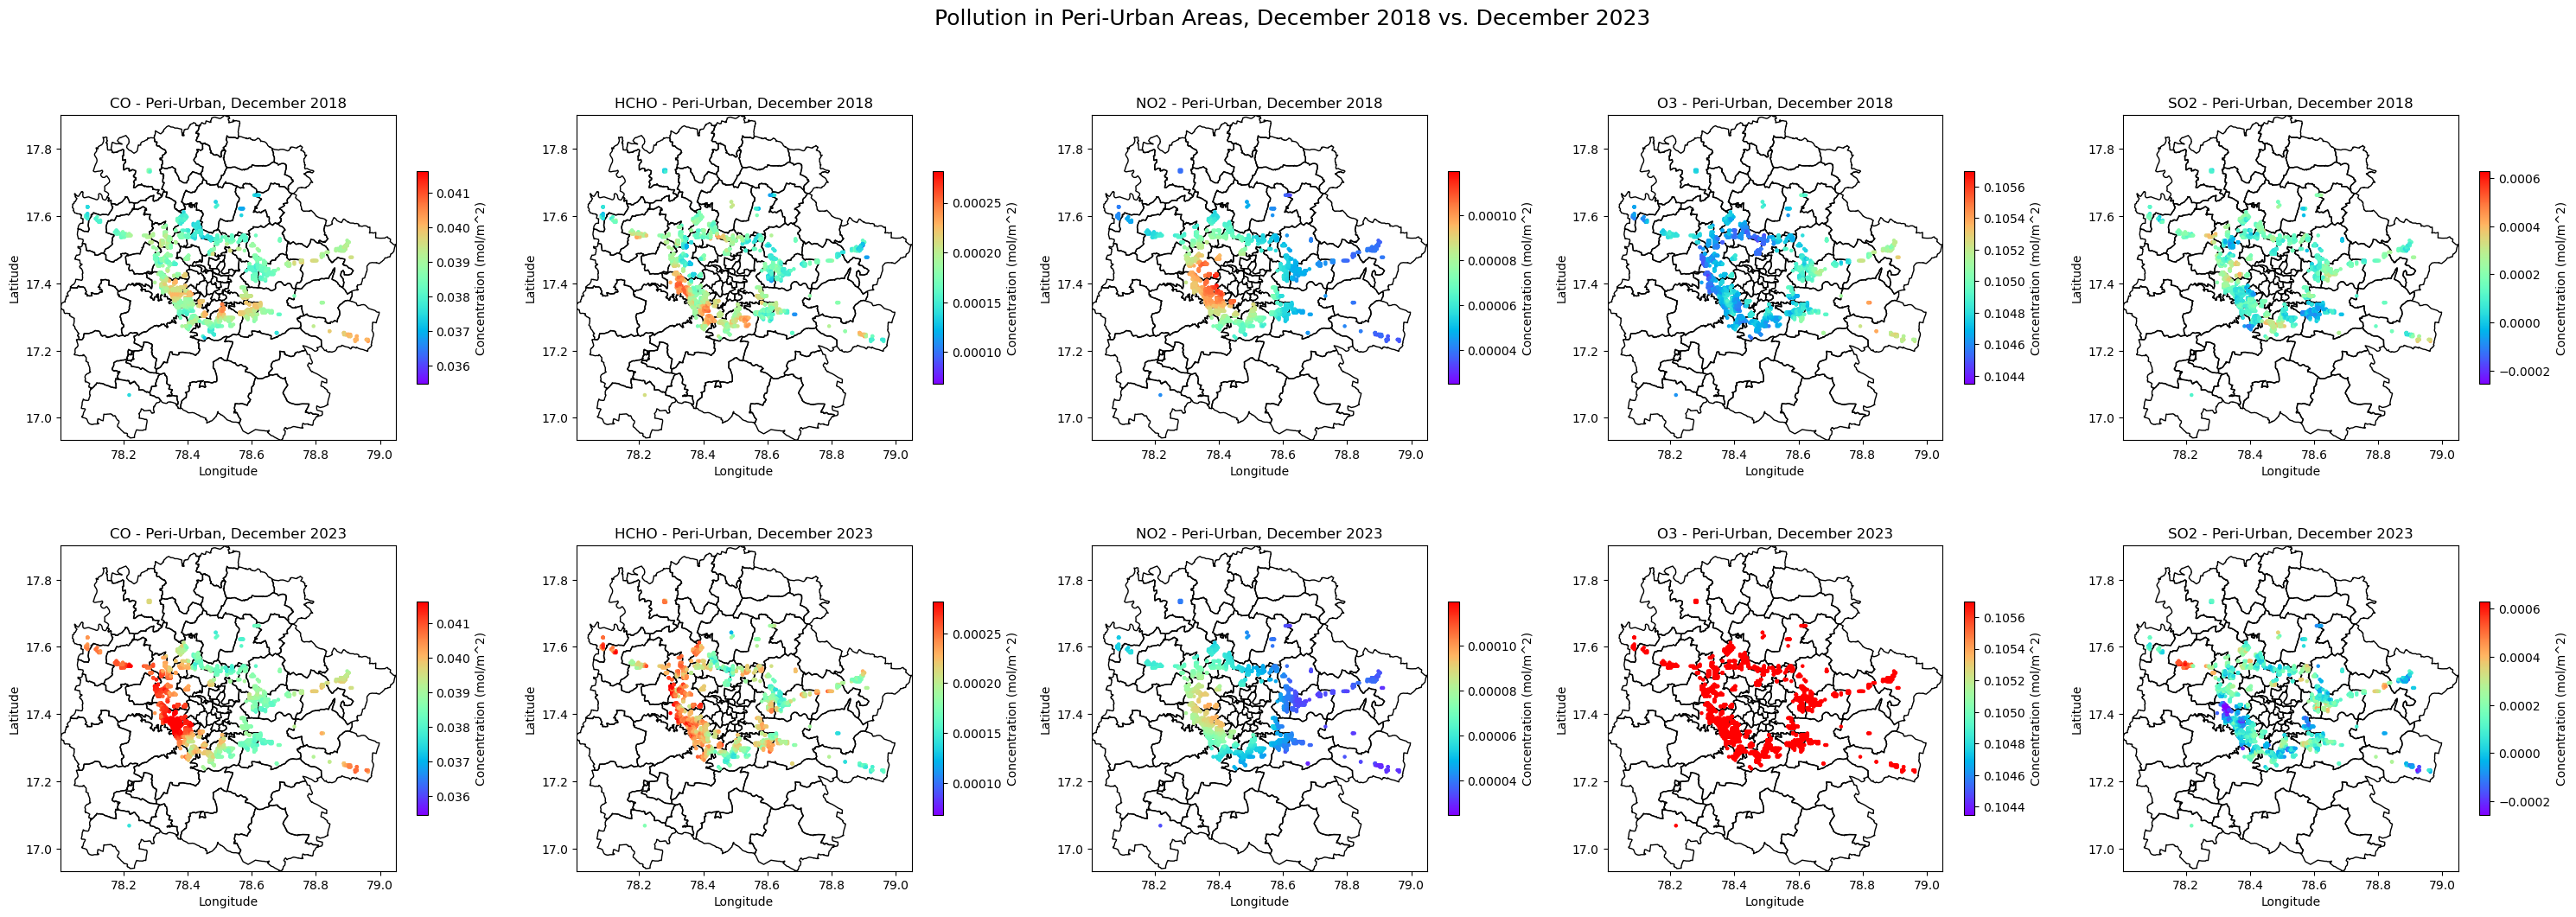

In [34]:
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'

# Load the shapefile and GeoDataFrames
shape_data = gpd.read_file(shapefile_path)
gdf_peri = gdf_points_peri  # Peri-urban points
gdf_urban = gdf_points_urban  # Urban points

# Create a figure with 15 subplots (5 TIFFs * 3 views)
fig, axes = plt.subplots(2,5, figsize=(30, 11))  # 5 rows, 3 columns
fig.suptitle('Pollution in Peri-Urban Areas, December 2018 vs. December 2023', fontsize=18)

cmap_scales = []

# Iterate over TIFF files and create three plots for each
for i, tif_path in enumerate(tif_paths):
    if(i in range (0,5)):
    # Open the TIFF file
        with rasterio.open(tif_path) as src:
            raster_data = src.read(1)
            bounds = src.bounds
            vmin, vmax = np.nanmin(raster_data), np.nanmax(raster_data)  # Scale
            cmap_scales.append((vmin, vmax))

            def extract_raster_value(gdf, src):
                return gdf['geometry'].apply(
                    lambda point: (
                        raster_data[src.index(point.x, point.y)]
                        if 0 <= point.x < src.width and 0 <= point.y < src.height
                        else np.nan
                    )
                )

            # Extract raster values for both GeoDataFrames
            gdf_peri['raster_value'] = extract_raster_value(gdf_peri, src)
            gdf_urban['raster_value'] = extract_raster_value(gdf_urban, src)
        m = tif_path.split(os.sep)
        # if(i==3):
        #     vmin,vmax=omap
        # Plot 1: Peri-urban points
        ax = axes[0,i]
        shape_data.plot(ax=ax, color='none', edgecolor='black')
        gdf_peri.plot(ax=ax, column='raster_value', cmap='rainbow', markersize=5, legend=True,
                    legend_kwds={'shrink': 0.5, 'label': "Concentration (mol/m^2)"}, vmin=vmin, vmax=vmax)
        ax.set_xlim(bounds.left, bounds.right)
        ax.set_ylim(bounds.bottom, bounds.top)
        ax.set_title(f'{m[6]} - Peri-Urban, December 2018')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

    else:
        with rasterio.open(tif_path) as src:
            raster_data = src.read(1)
            bounds = src.bounds
            vmin, vmax = np.nanmin(raster_data), np.nanmax(raster_data)  # Scale

            def extract_raster_value(gdf, src):
                return gdf['geometry'].apply(
                    lambda point: (
                        raster_data[src.index(point.x, point.y)]
                        if 0 <= point.x < src.width and 0 <= point.y < src.height
                        else np.nan
                    )
                )

            # Extract raster values for both GeoDataFrames
            gdf_peri['raster_value'] = extract_raster_value(gdf_peri, src)
            gdf_urban['raster_value'] = extract_raster_value(gdf_urban, src)
        m = tif_path.split(os.sep)
        # Plot 1: Peri-urban points

        vmin,vmax=cmap_scales[i-5]
        # if(i==3+5):
        #     vmin,vmax=omap
        ax = axes[1, i-5]
        shape_data.plot(ax=ax, color='none', edgecolor='black')
        gdf_peri.plot(ax=ax, column='raster_value', cmap='rainbow', markersize=5, legend=True,
                    legend_kwds={'shrink': 0.5,'label': "Concentration (mol/m^2)"}, vmin=vmin, vmax=vmax)
        ax.set_xlim(bounds.left, bounds.right)
        ax.set_ylim(bounds.bottom, bounds.top)
        ax.set_title(f'{m[6]} - Peri-Urban, December 2023')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

# Adjust layout to prevent overlap
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


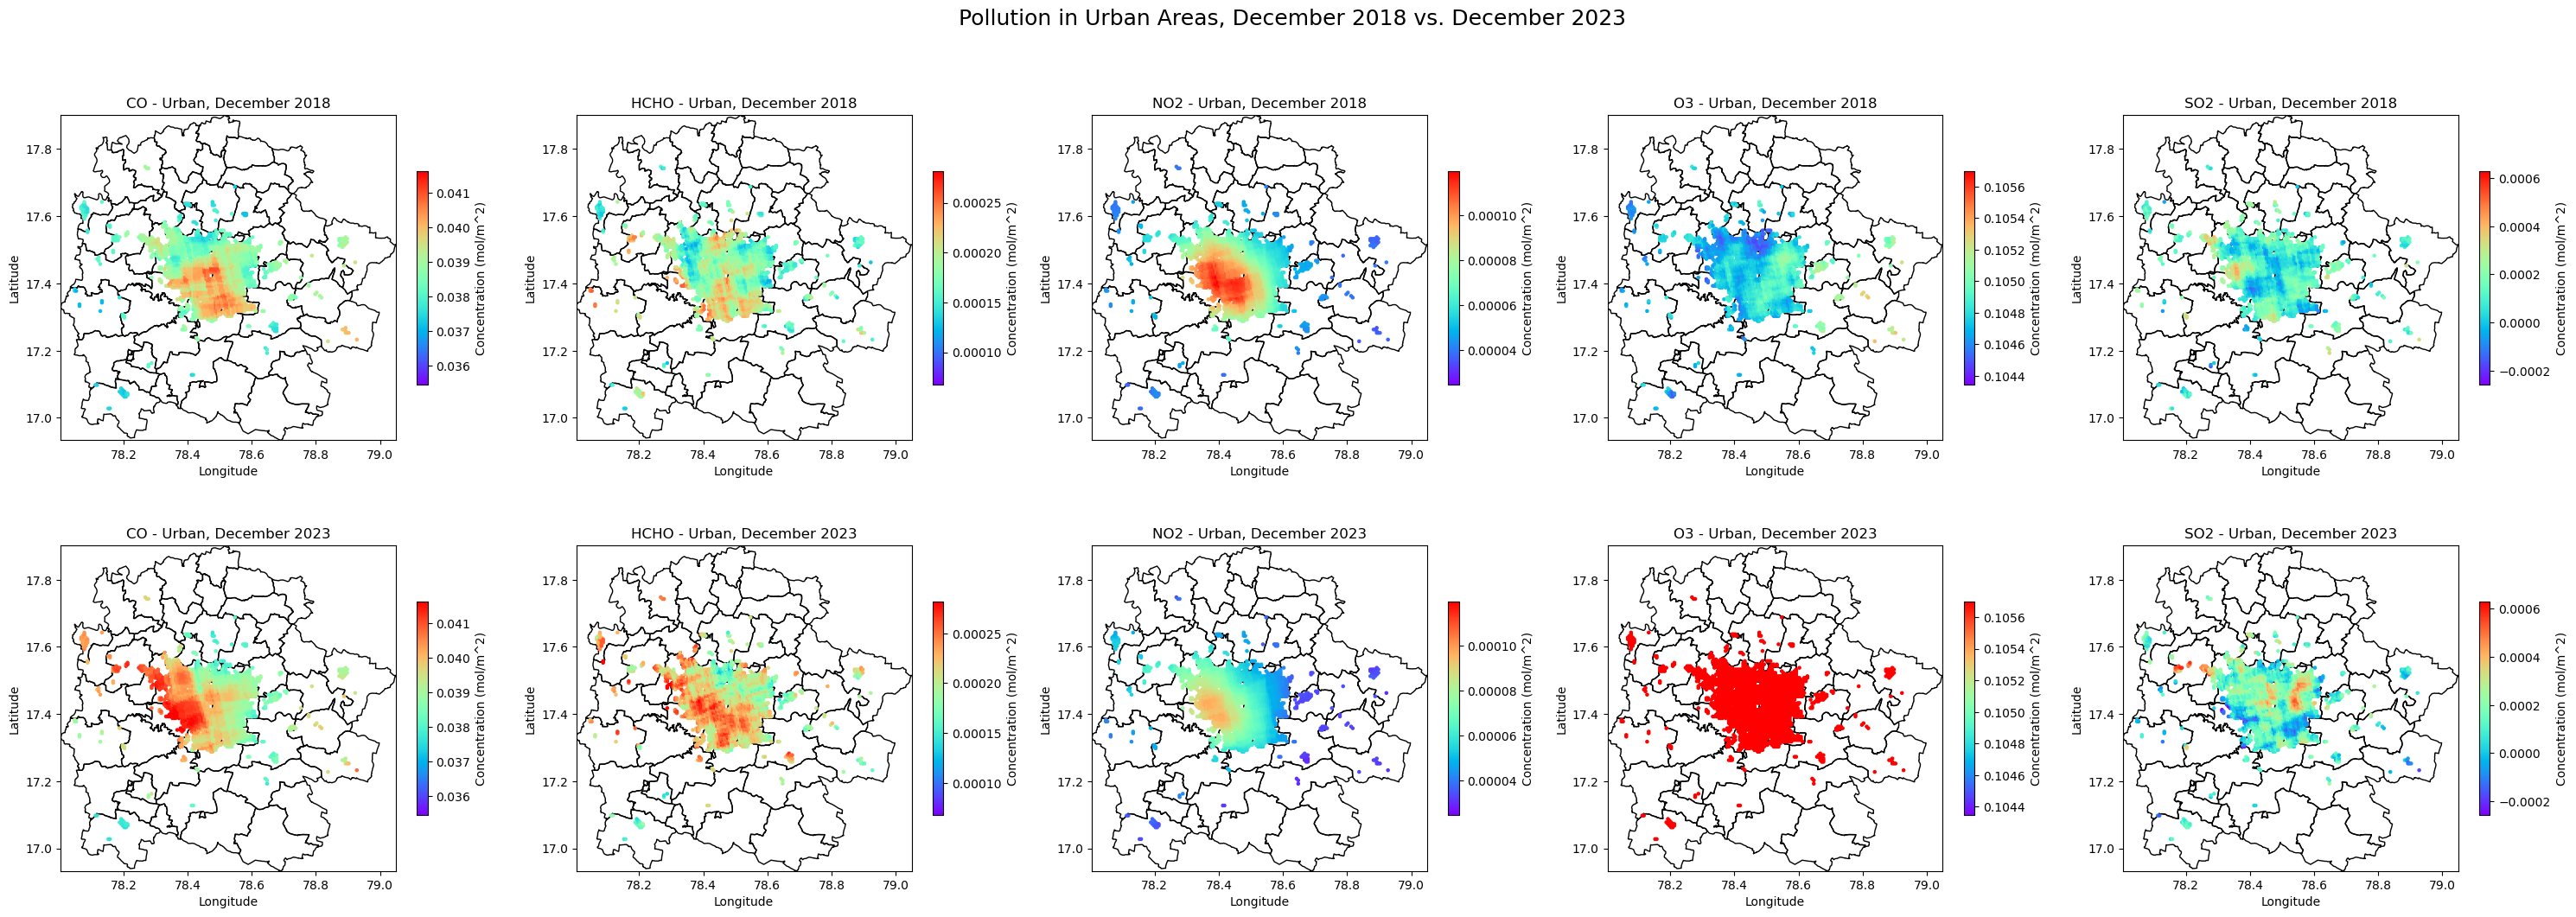

In [35]:
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'

# Load the shapefile and GeoDataFrames
shape_data = gpd.read_file(shapefile_path)
gdf_peri = gdf_points_peri  # Peri-urban points
gdf_urban = gdf_points_urban  # Urban points

# Create a figure with 15 subplots (5 TIFFs * 3 views)
fig, axes = plt.subplots(2,5, figsize=(30, 11))  # 5 rows, 3 columns
fig.suptitle('Pollution in Urban Areas, December 2018 vs. December 2023', fontsize=18)

cmap_scales = []

# Iterate over TIFF files and create three plots for each
for i, tif_path in enumerate(tif_paths):
    if(i in range (0,5)):
    # Open the TIFF file
        with rasterio.open(tif_path) as src:
            raster_data = src.read(1)
            bounds = src.bounds
            vmin, vmax = np.nanmin(raster_data), np.nanmax(raster_data)  # Scale
            cmap_scales.append((vmin, vmax))

            def extract_raster_value(gdf, src):
                return gdf['geometry'].apply(
                    lambda point: (
                        raster_data[src.index(point.x, point.y)]
                        if 0 <= point.x < src.width and 0 <= point.y < src.height
                        else np.nan
                    )
                )

            # Extract raster values for both GeoDataFrames
            gdf_peri['raster_value'] = extract_raster_value(gdf_peri, src)
            gdf_urban['raster_value'] = extract_raster_value(gdf_urban, src)
        m = tif_path.split(os.sep)
        # if(i==3):
        #     vmin,vmax=omap
        # Plot 1: Peri-urban points
        ax = axes[0,i]
        shape_data.plot(ax=ax, color='none', edgecolor='black')
        gdf_urban.plot(ax=ax, column='raster_value', cmap='rainbow', markersize=5, legend=True,
                    legend_kwds={'shrink': 0.5, 'label': "Concentration (mol/m^2)"}, vmin=vmin, vmax=vmax)
        ax.set_xlim(bounds.left, bounds.right)
        ax.set_ylim(bounds.bottom, bounds.top)
        ax.set_title(f'{m[6]} - Urban, December 2018')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

    else:
        with rasterio.open(tif_path) as src:
            raster_data = src.read(1)
            bounds = src.bounds
            vmin, vmax = np.nanmin(raster_data), np.nanmax(raster_data)  # Scale

            def extract_raster_value(gdf, src):
                return gdf['geometry'].apply(
                    lambda point: (
                        raster_data[src.index(point.x, point.y)]
                        if 0 <= point.x < src.width and 0 <= point.y < src.height
                        else np.nan
                    )
                )

            # Extract raster values for both GeoDataFrames
            gdf_peri['raster_value'] = extract_raster_value(gdf_peri, src)
            gdf_urban['raster_value'] = extract_raster_value(gdf_urban, src)
        m = tif_path.split(os.sep)
        # Plot 1: Peri-urban points

        vmin,vmax=cmap_scales[i-5]
        # if(i==3+5):
        #     vmin,vmax=omap
        ax = axes[1,i-5]
        shape_data.plot(ax=ax, color='none', edgecolor='black')
        gdf_urban.plot(ax=ax, column='raster_value', cmap='rainbow', markersize=5, legend=True,
                    legend_kwds={'shrink': 0.5,'label': "Concentration (mol/m^2)"}, vmin=vmin, vmax=vmax)
        ax.set_xlim(bounds.left, bounds.right)
        ax.set_ylim(bounds.bottom, bounds.top)
        ax.set_title(f'{m[6]} - Urban, December 2023')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

# Adjust layout to prevent overlap
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
